In [38]:
#@title
import numpy as np
from scipy.stats import qmc
import matplotlib.pyplot as plt

epsilon = 1e-3

def get_distance(x1, x2):
  return np.sqrt((x1[0]-x2[0])**2 + (x1[1]-x2[1])**2)

def plotting_code(X, A):
    """
   Inputs:
    X --> (nx x 2) matrix with coordinates of the sensors
    A --> (na x 2) matrix with coordinates of the anchors

    Output:
    Plot of X, A on a 1x1 grid
    """
    plt.scatter(X[:, 0], X[:, 1], color='red', label='Sensors')
    plt.scatter(A[:, 0], A[:, 1], color='blue', label='Anchors')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    #plt.title('Visualization of Grid')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.show()
    return

def get_data(nx, na, r = (2**0.5), plotter=False):
  '''
  Inputs:
    nx --> number of sensors
    n1 --> number of anchors
    r --> threshold radius
  
  Outputs:
    X --> (nx x 2) matrix with coordinates of the sensors
    A --> (na x 2) matrix with coordinates of the anchors
    D --> (nx x nx) matrix with D[i,j] as the distance between sensor i and j for all i<j
    D_hat --> (na x nx) matrix with D_hat[k,j] as the distance between anchor k and sensor j
  '''
  # we set seed for reproducibility of code
  np.random.seed(1)

  # A = np.random.uniform(low=0.0, high=1.0, size=(na,2))
  # We use a quasirandom space-filling set Halton for anchor pts
  sampler = qmc.Halton(d=2, scramble=False, seed=10)
  A = sampler.random(na)

  X = np.random.uniform(low=0.0, high=1.0, size=(nx,2))
  D = np.zeros((nx,nx))
  D_hat = np.zeros((na,nx))
  for i in range(nx):
    for j in range(i+1,nx):
      dist = get_distance(X[i], X[j]) #+ np.random.randn()*0.1
      if  dist < r:
        D[i,j] = dist
  for i in range(na):
    for j in range(nx):
      dist = get_distance(A[i], X[j]) #+ np.random.randn()*0.1
      if dist < r:
        D_hat[i,j] = dist
  #here we plot the anchors and real sensors
  if plotter:
    plotting_code(X, A)

  return X, A, D, D_hat


def get_distances_from_anchors(X_est, A, r=2**0.05):
  na = A.shape[0]
  nx = X_est.shape[0]
  D_est = np.zeros((nx,nx))
  D_hat_est = np.zeros((na,nx))
  for i in range(nx):
    for j in range(i+1,nx):
      dist = get_distance(X_est[i], X_est[j])
      if  dist < r:
        D_est[i,j] = dist
  for i in range(na):
    for j in range(nx):
      dist = get_distance(A[i], X_est[j])
      if dist < r:
        D_hat_est[i,j] = dist
  return D_est, D_hat_est

def sanity_checks(X_est, A, Z=None):
  D_est, D_hat_est = get_distances_from_anchors(X_est, A)
  if (D_est <= D + epsilon).all():
    print('D_est <= D: PASS')
  else:
    print('D_est <= D: FAIL')
  if (D_hat_est <= D_hat + epsilon).all():
    print('D_hat_est <= D_hat: PASS')
  else:
    print('D_hat_est <= D_hat: FAIL')
  if Z is not None:
    if np.all(np.linalg.eigvals(Z) + epsilon >= 0):
      print('Z >> 0 : PASS')
    else:
      print('Z >> 0: FALL')
  
def plotter_with_estimation(X, A, X_est, title='Visualization of Grid', anchors=True):
    x_optimal = X_est 
    if X_est is not None:
      plt.scatter(x_optimal[:, 0], x_optimal[:, 1], alpha = 0.9,label = "Estimated", color='green')
    plt.scatter(X[:, 0], X[:, 1], color='red', label='Real Sensors', marker = '+')
    if anchors:
      plt.scatter(A[:, 0], A[:, 1], color='blue', label='Anchors', marker="*")
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(title)
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.legend()
    plt.grid(True)
    plt.show()

def generate_points_on_perimeter(n):
    points = []
    interval = 1 / (n - 1)
    if n > 4: 
      # Generate points along the bottom side
      for i in range(n//4):
          points.append([4 * i * interval, 0])

      # Generate points along the right side
      for i in range((n - 1)//4):
          points.append([1, 4 * (i + 1) * interval])

      # Generate points along the top side
      for i in range((n - 1)//4):
          points.append([1 - 4 * (i + 1) * interval, 1])

      # Generate points along the left side
      for i in range((n - 1)//4):
          points.append([0, 1 - 4 * (i + 1) * interval])
    else:
      points = [[0,0], [1,1], [0,1], [1, 0]][:n]

    # Add extra points if necessary
    while len(points) < n:
      x = np.random.uniform(0, 1)
      if x < 0.5:
          points.append([x, 0])
      else:
          points.append([1, x - 0.5])

    return np.array(points).reshape(n, 2)

def average_distance(matrix1, matrix2):
    num_points = len(matrix1)
    distances = np.linalg.norm(matrix1 - matrix2, axis=1)
    avg_distance = np.sum(distances) / num_points
    return avg_distance


def get_noisy_data(nx, na, r=(2 ** 0.5), noise_std=0.1, seed = 0,  on_perimeter=False, plotter=False):
    '''
    Inputs:
      nx --> number of sensors
      na --> number of anchors
      r --> threshold radius
      noise_std --> standard deviation of the added noise
  
    Outputs:
      X --> (nx x 2) matrix with coordinates of the sensors
      A --> (na x 2) matrix with coordinates of the anchors
      D --> (nx x nx) matrix with D[i,j] as the distance between sensor i and j for all i<j
      D_hat --> (na x nx) matrix with D_hat[k,j] as the distance between anchor k and sensor j
    '''
    # Set seed for reproducibility of code
    np.random.seed(seed)

    # We use a quasirandom space-filling set Halton for anchor pts
    if on_perimeter:
      A = generate_points_on_perimeter(na)
    else:
      sampler = qmc.Halton(d=2, scramble=False, seed=10)
      A = sampler.random(na)

    X = np.random.uniform(low=0.0, high=1.0, size=(nx, 2))
    D = np.zeros((nx, nx))
    D_hat = np.zeros((na, nx))

    for i in range(nx):
        for j in range(i + 1, nx):
            dist = get_distance(X[i], X[j])*(1 + np.random.randn() * noise_std)
            if dist < r:
                D[i, j] = dist

    for i in range(na):
        for j in range(nx):
            dist = get_distance(A[i], X[j])*(1+ + np.random.randn() * noise_std)
            if dist < r:
                D_hat[i, j] = dist

    # Plot the anchors and real sensors if plotter is True
    if plotter:
        plotting_code(X, A)

    return X, A, D, D_hat

def get_rmsd(x1, x2):
  n = x1.shape[0]
  return np.sqrt((np.linalg.norm(x1-x2, axis=1)**2).sum()/n)


In [2]:
#@title
import cvxpy as cp
import pdb

def socp(Nx, A, D, D_hat, scs=True):
  # now we use optimization techniques to locate sensors with our anchor points.
  # Define and solve the CVXPY problem.
  x = cp.Variable((Nx, 2))
  # Define the objective function
  objective = cp.Minimize(0)

  # Define the constraints
  # We use cp.SOC(t, x) to create the SOC constraint ||x||_2 <= t.

  constraints = []
  for i in range(Nx):
    for j in range(i+1, Nx):
      #constraints.append(cp.norm(x[i] - x[j], 2) <= D[i][j])
      if D[i][j]>0:
        constraints.append(cp.SOC(D[i][j], x[i]-x[j]))
  for k in range(Na):
    for j in range(Nx):
      #constraints.append(cp.norm(A[k] - x[j], 2) <= D_hat[k][j])
      if D_hat[k][j]>0:
        constraints.append(cp.SOC(D_hat[k][j], A[k]-x[j]))
      
  # Create the problem instance
  prob = cp.Problem(objective, constraints)
  if scs:
    prob.solve(solver=cp.SCS,verbose=False)
  else:
    prob.solve(verbose=False)

  return (np.array(x.value))

def sdp(Nx, A, D, D_hat):
  AT = A.T

  def get_eij_with_zero(i,j, nx):
    eij = get_ei(i, nx) - get_ei(j, nx)
    zero_vector = np.array([[0],[0]])
    return np.concatenate((zero_vector, eij), axis=0)

  def get_ei(i, nx):
    ei = np.zeros((nx, 1))
    ei[i] = 1
    return ei


  def get_ak_ej(k, j, a, nx):
    ak = a[:, k].reshape((2,1))
    ej = get_ei(j, nx)
    return np.concatenate((ak, -ej),axis=0)

  def dot_operator(p,q):
    return np.sqrt(np.trace(p.T@q))

  x = cp.Variable((2+Nx,2+Nx), symmetric=True)

  # must be symmetric positive semi definite
  constraints = [x >> 0]

  # constraints 2 and 3 from image
  for i in range(Nx):
    for j in range(i+1, Nx):
      if D[i][j]>0:
        eij = get_eij_with_zero(i, j, Nx)
        constraints.append( cp.trace((eij@eij.T).T@x) == D[i,j]**2)
  for k in range(Na):
    for j in range(Nx):
      if D_hat[k][j]>0:
        akej = get_ak_ej(k, j, AT, Nx)
        constraints.append( cp.trace((akej@akej.T).T@x) == D_hat[k,j]**2)

  # first constraint: first block of Z is Identity

  #constraints.append(cp.diag(x[:2, :2]).value == [1, 1])
  # constraints.append(x[0, 1] == 0)
  # constraints.append(x[1, 0] == 0)

  zd = np.zeros(((2+Nx), (2+Nx)))
  zd[0,0] = 1
  constraints.append(cp.trace(zd@x) == 1)

  zd = np.zeros(((2+Nx), (2+Nx)))
  zd[0,1] = 1
  constraints.append(cp.trace(zd@x) == 0)

  zd = np.zeros(((2+Nx), (2+Nx)))
  zd[1,0] = 1
  constraints.append(cp.trace(zd@x) == 0)

  zd = np.zeros(((2+Nx), (2+Nx)))
  zd[1,1] = 1
  constraints.append(cp.trace(zd@x) == 1)

  # solve
  objective = cp.Minimize(0)
  prob = cp.Problem(objective,
                    constraints)

  prob.solve(verbose=False)

  #return np.array(x.value), np.array(x.value)[0:2, 2:].T
  return np.array(x.value)[0:2, 2:].T

# clearly cvxpy is unhappy. lets try numpy
from scipy.optimize import least_squares

def lsq(Nx,A,D,D_hat, x_initial=None):
  if x_initial is None:
    x_initial = np.random.uniform(low=0.0, high=1.0, size=(Nx, 2)).flatten()
  def objective_function(x):
      x = x.reshape((Nx, 2))  # Reshape x back to (Nx, 2) array
      objective = []
      for i in range(Nx):
          for j in range(i + 1, Nx):
              if D[i][j] > 0:
                  objective.append((np.linalg.norm(x[i] - x[j]) ** 2 - D[i][j] ** 2) ** 2)
      for i in range(Na):
          for j in range(Nx):
              if D[i][j] > 0:
                  objective.append((np.linalg.norm(A[i] - x[j]) ** 2 - D_hat[i][j] ** 2) ** 2)
      return objective

  #x_initial = np.random.uniform(low=0.0, high=1.0, size=(Nx, 2))
  #x_initial = x_initial.flatten()  # Reshape to a single dimension
  bounds = (-10, 10)  # Bounds for x variables, if any

  result = least_squares(objective_function, x_initial, bounds=bounds)
  return result.x.reshape((Nx, 2))


def sdp_noise(Nx, A, D, D_hat):
    AT = A.T

    def get_eij_with_zero(i, j, nx):
        eij = get_ei(i, nx) - get_ei(j, nx)
        zero_vector = np.array([[0], [0]])
        return np.concatenate((zero_vector, eij), axis=0)

    def get_ei(i, nx):
        ei = np.zeros((nx, 1))
        ei[i] = 1
        return ei

    def get_ak_ej(k, j, a, nx):
        ak = a[:, k].reshape((2, 1))
        ej = get_ei(j, nx)
        return np.concatenate((ak, -ej), axis=0)

    def dot_operator(p, q):
        return np.sqrt(np.trace(p.T @ q))

    x = cp.Variable((2 + Nx, 2 + Nx), symmetric=True)
    delta = cp.Variable(D.shape, nonneg=True)
    delta_prime = cp.Variable(D.shape, nonneg=True)
    delta_hat = cp.Variable(D_hat.shape, nonneg=True)
    delta_hat_prime = cp.Variable(D_hat.shape, nonneg=True)

    # must be symmetric positive semi definite
    constraints = [x >> 0]
    constraints.append(delta>=0)
    constraints.append(delta_prime>=0)
    constraints.append(delta_hat>=0)
    constraints.append(delta_hat_prime>=0)

    # constraints 2 and 3 from image
    for i in range(Nx):
        for j in range(i + 1, Nx):
            if D[i][j] > 0:
                eij = get_eij_with_zero(i, j, Nx)
                constraints.append(cp.trace((eij @ eij.T).T @ x) + delta[i, j] - delta_prime[i,j] == D[i, j] ** 2)

    for k in range(Na):
        for j in range(Nx):
            if D_hat[k][j] > 0:
                akej = get_ak_ej(k, j, AT, Nx)
                constraints.append(cp.trace((akej @ akej.T).T @ x) +  delta_hat[k, j] - delta_hat_prime[k,j]  == D_hat[k, j] ** 2)

    # first constraint: first block of Z is Identity
    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[0, 0] = 1
    constraints.append(cp.trace(zd @ x) == 1)

    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[0, 1] = 1
    constraints.append(cp.trace(zd @ x) == 0)

    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[1, 0] = 1
    constraints.append(cp.trace(zd @ x) == 0)

    zd = np.zeros(((2 + Nx), (2 + Nx)))
    zd[1, 1] = 1
    constraints.append(cp.trace(zd @ x) == 1)

    # minimize element-wise L1 norm
    objective = cp.Minimize(cp.sum(delta + delta_prime) + cp.sum(delta_hat + delta_hat_prime))

    prob = cp.Problem(objective, constraints)
    prob.solve(verbose=False)
    # print(delta.value, delta_hat.value)
    return np.array(x.value)[0:2, 2:].T

In [ ]:
Nx, Na = 25, 10
X, A, D, D_hat = get_data(Nx, Na, plotter=False)

In [ ]:
X_est = sdp(Nx, A, D, D_hat)


In [ ]:
dist = np.sqrt((np.linalg.norm(X-X_est_socp, axis=1)**2).sum()/Nx)

In [ ]:
dist

0.41070819036925066

In [ ]:
#Finding the distances D and D_hat with the estimated X
X_est = socp(Nx, A, D, D_hat)
sanity_checks(X_est, A)
plotter_with_estimation(X, A, X_est)

Z_est, X_est = sdp(Nx, A, D, D_hat)
print(X_est.shape)
sanity_checks(X_est, A, Z = Z_est)
plotter_with_estimation(X, A, X_est)

X_est =  lsq(Nx,A,D,D_hat)
plotter_with_estimation(X, A, X_est)

Z_est, X_est_noise_sdp = sdp_noise(Nx, A, D, D_hat)
plotter_with_estimation(X, A, X_est_noise_sdp)
print(X_est_noise_sdp.shape)

In [ ]:
n = 3
points = [[0,0], [1,1], [0,1], [1, 0]][:n]
print(points)
num_points = 10
points = generate_points_on_perimeter(num_points)
points[:, 1]
plt.scatter(points[: , 0], points[:, 1])

[[0, 0], [1, 1], [0, 1]]


With Noisy Data - DONE

Comparing approaches 2,3,4 vs approach 5 --> Amod 

Comparing approach 5 with approach 4 starting from the solution of approach 5 - DONE


For the house case, we can set the anchors at the corner/convex hull of the room

For the wildlife case, we use the space filling case. 

Metrics:

average distance error 

Parameters: 

Sensors: [10,50,100]
Anchors: [5,10,25]


Whats a good sensor to anchor ratio for all the approaches?
Runtime vs performance tradefoffs for all the approaches?



In [ ]:


avg_dist = average_distance(matrix1, matrix2)
print(avg_dist)

1.1380711874576983


In [ ]:
# now to apply solution from (5) to NLLSQ
X_est =  lsq(Nx, A, D, D_hat, X_est_noise_sdp.flatten())
plotter_with_estimation(X, A, X_est)

In [22]:
#@title


def sdp_projection(Nx, A, D, D_hat, lr = 1e-4, X_sdp=None, iter=1000):
  def project(Zhat_k):
    from scipy.linalg import eigh
    D, V = eigh(Zhat_k)
    lb = np.zeros_like(D)
    #pdb.set_trace()
    Z_k = V @ np.diag(np.maximum(D, lb)) @ V.T
    return Z_k
  
  def get_eij_with_zero(i,j, nx):
    eij = get_ei(i, nx) - get_ei(j, nx)
    zero_vector = np.array([[0],[0]])
    return np.concatenate((zero_vector, eij), axis=0)

  def get_ei(i, nx):
    ei = np.zeros((nx, 1))
    ei[i] = 1
    return ei


  def get_ak_ej(k, j, a, nx, lr=3e-3):
    ak = a[:, k].reshape((2,1))
    ej = get_ei(j, nx)
    return np.concatenate((ak, -ej),axis=0)

  def dot_operator(p,q):
    return np.sqrt(np.trace(p.T@q))

  #lr = 3e-3
  AT = A.T
  Z = np.eye(Nx+2)
  grad = np.zeros((Nx+2,Nx+2))

  from tqdm import tqdm
  obj_old = 1e5
  err = []
  for it in range(iter):
    for i in range(Nx):
      for j in range(i+1, Nx):
        if D[i][j]>0:
          eij = get_eij_with_zero(i, j, Nx)
          Ai = (eij@eij.T)
          Ai_Z = np.sum(Ai*Z)
          b = D[i,j]**2
          grad += Ai * (Ai_Z-b)
          
    for k in range(Na):
      for j in range(Nx):
        if D_hat[k][j]>0:
          akej = get_ak_ej(k, j, AT, Nx)
          Ai = akej@akej.T
          Ai_Z = np.sum(Ai*Z)
          b = D_hat[k,j]**2
          grad += Ai * (Ai_Z-b)
    
    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[0,0] = 1
    Ai = zd
    Ai_Z = np.sum(Ai*Z)
    b = 1
    grad += Ai * (Ai_Z-b)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[0,1] = 1
    Ai = zd
    Ai_Z = np.sum(Ai*Z)
    b = 0
    grad += Ai * (Ai_Z-b)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[1,0] = 1
    Ai = zd
    Ai_Z = np.sum(Ai*Z)
    b = 0
    grad += Ai * (Ai_Z-b)

    zd = np.zeros(((2+Nx), (2+Nx)))
    zd[1,1] = 1
    Ai = zd
    Ai_Z = np.sum(Ai*Z)
    b = 1
    grad += Ai * (Ai_Z-b)

    Zhat = Z - lr*grad

    Z = project(Zhat)

    # if X_sdp is not None:
    #    err.append(np.linalg.norm(Z[0:2, 2:].T - X_sdp))


    obj_new = np.linalg.norm((Ai_Z-b))
    if X_sdp is not None:
       err.append(obj_new)
    if abs(obj_new - obj_old) < 1e-9:
      return Z[0:2, 2:].T, err
    if it%500 == 0:
      #print(abs(obj_new-obj_old))
      pass
    obj_old = obj_new
    

  
  return Z[0:2, 2:].T, err




    

In [ ]:
X_est = sdp_projection(Nx, A, D, D_hat)

 73%|███████▎  | 3639/5000 [00:40<00:15, 90.72it/s] 


In [ ]:
plotter_with_estimation(X, A, X_est)

In [31]:
from cvxpy.problems.objective import Objective
from tqdm import tqdm
# trying admm

np.random.seed(1)

def admm(Nx, A, D, D_hat, x=None, y=None, mu=None, beta=1):
  #first optimize for x
  if x is None:
    x = np.random.rand(Nx,2)
    y = np.random.rand(Nx,2)
    mu = np.random.rand(Nx,2)

  def get_obj(x,y,mu):
    obj=0
    for i in range(Nx):
      for j in range(i+1, Nx):
        if D[i][j]>0:
          #obj += (cp.sum(cp.multiply((x[i]-x[j]),(y[i]-y[j]))) - D[i,j]**2)**2
          obj += (np.sum((x[i]-x[j])*(y[i]-y[j])) - D[i,j]**2)**2
    for k in range(Na):
      for j in range(Nx):
        if D_hat[k][j]>0:
          #obj += (cp.sum(cp.multiply((A[k]-x[j]),(A[k]-y[j]))) - D_hat[k,j]**2)**2
          obj += (np.sum((A[k]-x[j])*(A[k]-y[j])) - D_hat[k,j]**2)**2
    # for i in range(Nx):
    #   obj-= cp.sum(cp.multiply(mu[i],(x[i]-y[i]))) 
    #   obj+= (beta/2)*cp.norm(x[i]-y[i])**2
    
    #pdb.set_trace()
    return obj



  obj_old = get_obj((x+y)/2,(x+y)/2,mu)
  for it in tqdm(range(1000)):
    obj = 0
    x = cp.Variable((Nx, 2))
    for i in range(Nx):
      for j in range(i+1, Nx):
        if D[i][j]>0:
          obj += (cp.sum(cp.multiply((x[i]-x[j]),(y[i]-y[j]))) - D[i,j]**2)**2
    for k in range(Na):
      for j in range(Nx):
        if D_hat[k][j]>0:
          obj += (cp.sum(cp.multiply((A[k]-x[j]),(A[k]-y[j]))) - D_hat[k,j]**2)**2
    for i in range(Nx):
      obj-= cp.sum(cp.multiply(mu[i],(x[i]-y[i]))) 
      obj+= (beta/2)*cp.norm(x[i]-y[i])**2
    
    objective = cp.Minimize(obj)
    prob = cp.Problem(objective)
    prob.solve(verbose=False)
    x = np.array(x.value)
    #pdb.set_trace()
    
    #obj_val = get_obj(x,y,mu)

    # optimize for y
    obj=0
    y = cp.Variable((Nx, 2))
    for i in range(Nx):
      for j in range(i+1, Nx):
        if D[i][j]>0:
          obj += (cp.sum(cp.multiply((x[i]-x[j]),(y[i]-y[j]))) - D[i,j]**2)**2
    for k in range(Na):
      for j in range(Nx):
        if D_hat[k][j]>0:
          obj += (cp.sum(cp.multiply((A[k]-x[j]),(A[k]-y[j]))) - D_hat[k,j]**2)**2
    for i in range(Nx):
      obj-= cp.sum(cp.multiply(mu[i],(x[i]-y[i]))) 
      obj+= (beta/2)*cp.norm(x[i]-y[i])**2
    
    objective = cp.Minimize(obj)
    prob = cp.Problem(objective)
    prob.solve(verbose=False)
    y = np.array(y.value)
    #pdb.set_trace()
    
    mu -= beta*(x-y)

    obj_new = get_obj((x+y)/2,(x+y)/2,mu)
    #print(abs(obj_new-obj_old))
    if abs(obj_new-obj_old)<1e-9:
      #print(abs(obj_new-obj_old))
      #print(it)
      return (x+y)/2
    if it%200 == 0:
      print(abs(obj_new-obj_old))
      pass
    obj_old = obj_new


  return (x+y)/2

  
# X, A, D, D_hat = get_noisy_data(Nx, Na, r=0.5, noise_std=0, seed = 1,  on_perimeter=False, plotter=False)
# x = np.random.rand(Nx,2)
# y = np.random.rand(Nx,2)
# mu = np.random.rand(Nx,2)
# X_est = admm(Nx, A, D, D_hat, x, y, mu)
# plotter_with_estimation(X, A, X_est)

  



In [32]:
#@title
def admm_trial(Nx, A, D, D_hat, x, y, mu):
  x_new = np.zeros((Nx,2))
  beta = 1000
  for i in range(Nx):
    x_new[i] = x_new[i] - mu[i]
    x_new[i] += beta*(x[i]-y[i])
    for j in range(i+1, Nx):
      if D[i,j]>0:
        x_new[i] += 2* (np.sum((x[i]-x[j])*(y[i]-y[j])) - D[i,j]**2)*(y[i]-y[j])
  for k in range(Na):
    for j in range(Nx):
      if D_hat[k,j]>0:
        x_new[j] +=  2* (np.sum((A[k]-x[j])*(A[k]-y[j])) - D_hat[k,j]**2)*(y[j]-A[k])

  for i in range(Nx):
    x_new[i] = x_new[i] - mu[i]
    x_new[i] += beta*(x[i]-y[i])
    for j in range(i+1, Nx):
      if D[i,j]>0:
        x_new[i] += 2* (np.sum((x[i]-x[j])*(y[i]-y[j])) - D[i,j]**2)*(y[i]-y[j])
  for k in range(Na):
    for j in range(Nx):
      if D_hat[k,j]>0:
        x_new[j] +=  2* (np.sum((A[k]-x[j])*(A[k]-y[j])) - D_hat[k,j]**2)*(y[j]-A[k])        
  return x_new

x = np.random.rand(Nx,2)
y = np.random.rand(Nx,2)
mu = np.random.rand(Nx,2)
print(admm_trial(Nx, A, D, D_hat, x, y, mu))


[[-1.13143480e+00  3.23617544e+02]
 [-2.82107297e+02  2.07468612e+02]
 [-1.31911750e+03 -1.76392199e+03]
 [-2.54909153e+02 -6.96540648e+02]
 [-9.61721247e+02 -7.13675559e+02]
 [ 6.68289889e+02  1.29138006e+03]
 [ 6.89870255e+01 -8.23457560e-01]
 [-1.43235626e+02  4.98188633e+02]]


In [33]:
D_est, D_hat_est = get_distances_from_anchors(X_est, A, r=2**0.05)
np.linalg.norm((D - D_est))

NameError: ignored

In [34]:
np.linalg.norm((D_hat - D_hat_est))

NameError: ignored

  0%|          | 0/1 [00:00<?, ?it/s]

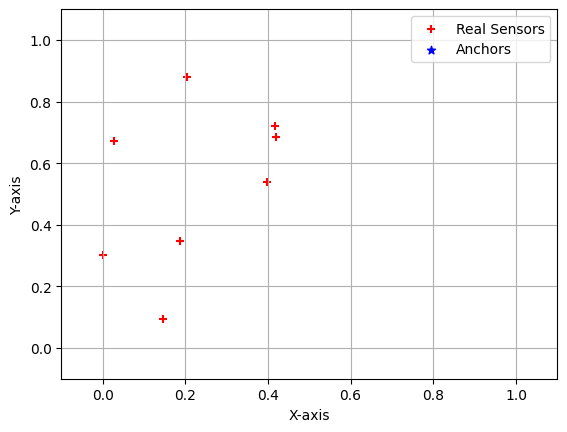

100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


In [42]:
#code for anchor placement 

#random case
socp_rmsd, sdp_rmsd, lsq_rmsd, sdp_lsq_rmsd, proj_rmsd, admm_rmsd = [], [], [], [], [], []

Nx, Na = 8, 0
for it in tqdm(range(1)):
  it=1
  X, A, D, D_hat = get_noisy_data(Nx, Na, r=1.5, noise_std=0, seed = it,  on_perimeter=False, plotter=False)
  plotter_with_estimation(X, A, None, title='')
  #X, A, D, D_hat = get_hull_data(Nx, Na, it, plotter=False)

  # X_socp = socp(Nx, A, D, D_hat)
  # socp_rmsd.append(get_rmsd(X, X_socp))
  # plotter_with_estimation(X, A, X_socp, title='Anchors placed randomly')
  # print('SOCP done')

  # X_lsq = lsq(Nx,A,D,D_hat, x_initial=None)
  # lsq_rmsd.append(get_rmsd(X, X_lsq))
  # plotter_with_estimation(X, A, X_lsq, title='Anchors placed randomly')
  # print('LS Done')

  # X_sdp = sdp_noise(Nx, A, D, D_hat)
  # sdp_rmsd.append(get_rmsd(X, X_sdp))
  # plotter_with_estimation(X, A, X_sdp, title='Anchors on perimeter')
  #print('SDP done')


  #X_sdp_lsq = lsq(Nx,A,D,D_hat, x_initial=X_sdp.flatten())
  #sdp_lsq_rmsd.append(get_rmsd(X, X_sdp_lsq))
  #print('SDP with LS done')
  #pdb.set_trace()

  # X_proj = sdp_projection(Nx, A, D, D_hat, lr=2e-3)
  # proj_rmsd.append(get_rmsd(X, X_proj))
  ##print('Proj done')

  # X_admm = admm(Nx, A, D, D_hat)
  # admm_rmsd.append(get_rmsd(X, X_admm))
  # plotter_with_estimation(X, A, X_admm, title='Sensors beyond convex hull of anchors')
  # print('Admm done')








In [ ]:
avg = np.average
print(avg(socp_rmsd), avg(lsq_rmsd),  avg(sdp_rmsd), avg(sdp_lsq_rmsd), avg(proj_rmsd), avg(admm_rmsd))

0.19398139530244826 0.5578402469497157 0.1751281540272593 0.5336341511913275 nan 0.16292197995022


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


<ipython-input-58-5042cd6997ae>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x)


{'whiskers': [<matplotlib.lines.Line2D at 0x7f5469c4db40>,
 'caps': [<matplotlib.lines.Line2D at 0x7f5469c4fc70>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f5469c4f4c0>,
 'medians': [<matplotlib.lines.Line2D at 0x7f5469c4df90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f5469c4e680>,
 'means': []}

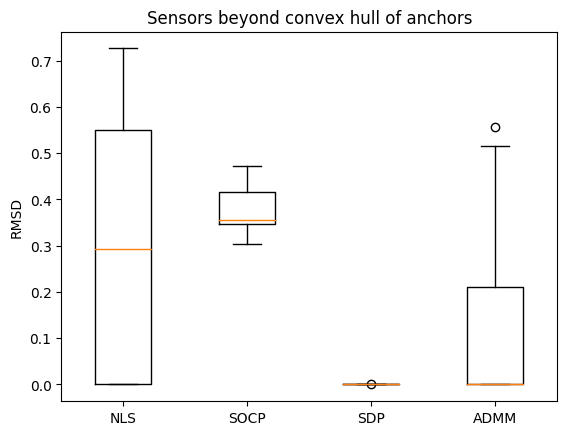

In [ ]:
import matplotlib.pyplot as plt
x = ['NLS', 'SOCP', 'SDP', 'ADMM']
y = [lsq_rmsd, socp_rmsd, sdp_rmsd, admm_rmsd]
fig = plt.figure()
ax = fig.add_subplot(111)
# Creating axes instance
ax.set_xticklabels(x)
ax.set_title('Sensors beyond convex hull of anchors')
ax.set_ylabel('RMSD')
 
# Creating plot
plt.boxplot(y)
#4,8,0,0.5

In [ ]:
X_socp

array(None, dtype=object)

In [24]:
def get_obj(x,y):
  obj=0
  for i in range(Nx):
    for j in range(i+1, Nx):
      if D[i][j]>0:
        #obj += (cp.sum(cp.multiply((x[i]-x[j]),(y[i]-y[j]))) - D[i,j]**2)**2
        obj += (np.sum((x[i]-x[j])*(y[i]-y[j])) - D[i,j]**2)**2
  for k in range(Na):
    for j in range(Nx):
      if D_hat[k][j]>0:
        #obj += (cp.sum(cp.multiply((A[k]-x[j]),(A[k]-y[j]))) - D_hat[k,j]**2)**2
        obj += (np.sum((A[k]-x[j])*(A[k]-y[j])) - D_hat[k,j]**2)**2
  # for i in range(Nx):
  #   obj-= cp.sum(cp.multiply(mu[i],(x[i]-y[i]))) 
  #   obj+= (beta/2)*cp.norm(x[i]-y[i])**2
  
  #pdb.set_trace()
  return obj


def get_hull_data(nx, na, seed, r=1.5, plotter=True, noise_std=0):
  np.random.seed(seed)
  lb = 0.4
  ub = 0.6
  A = np.array( [ [ub, ub], [lb, ub], [ub, lb], [lb, lb]])
  X = np.random.uniform(low=0.0, high=1.0, size=(nx,2))

  for i in range(nx):
    if X[i][0] > lb and X[i][0] < ub and X[i][1] > lb and X[i][1] < ub:
      xval = ub - X[i][0] if X[i][0] > 0.5 else X[i][0] - lb
      xdir = 1 if X[i][0] > 0.5 else 0
      yval = ub - X[i][1] if X[i][1] > 0.5 else X[i][1] - lb
      ydir = 1 if X[i][1] > 0.5 else 0
      if yval >= xval:
        X[i][1] = np.random.uniform(low=ub, high=1.0) if ydir else np.random.uniform(low=0, high=lb)
      else:
        X[i][0] = np.random.uniform(low=ub, high=1.0) if xdir else np.random.uniform(low=0, high=lb)



  D = np.zeros((nx,nx))
  D_hat = np.zeros((na,nx))
  for i in range(nx):
    for j in range(i+1,nx):
      dist = get_distance(X[i], X[j])*(1 + np.random.randn() * noise_std) #+ np.random.randn()*0.1
      if  dist < r:
        D[i,j] = dist
  for i in range(na):
    for j in range(nx):
      dist = get_distance(A[i], X[j])*(1 + np.random.randn() * noise_std) #+ np.random.randn()*0.1
      if dist < r:
        D_hat[i,j] = dist
  #here we plot the anchors and real sensors
  if plotter:
    plotting_code(X, A)

  return X, A, D, D_hat

In [ ]:
Nx = 15

anchors = [2,5,10,15]
socp_rmsd, sdp_rmsd, lsq_rmsd, sdp_lsq_rmsd, proj_rmsd, admm_rmsd = [], [], [], [], [], []


for Na in anchors:
  print(Na)
  socp_t, sdp_t, lsq_t, sdp_lsq_t, proj_t, admm_t = [], [], [], [], [], []
  for it in tqdm(range(1)):
    X, A, D, D_hat = get_noisy_data(Nx, Na, r=0.5, noise_std=0, seed = it,  on_perimeter=False, plotter=False)
    #X, A, D, D_hat = get_hull_data(Nx, Na, it, plotter=False)

    X_socp = socp(Nx, A, D, D_hat)
    socp_rmsd.append(get_rmsd(X, X_socp))
    plotter_with_estimation(X, A, X_socp, title='Anchors on perimeter')

    #print('SOCP done')

    X_lsq = lsq(Nx,A,D,D_hat, x_initial=None)
    lsq_rmsd.append(get_rmsd(X, X_lsq))
    plotter_with_estimation(X, A, X_lsq, title='Anchors on perimeter')

    #print('LS Done')

    X_sdp = sdp(Nx, A, D, D_hat)
    sdp_rmsd.append(get_rmsd(X, X_sdp))
    plotter_with_estimation(X, A, X_sdp, title='Anchors on perimeter')

    #print('SDP done')

    # X_sdp_lsq = lsq(Nx,A,D,D_hat, x_initial=X_sdp.flatten())
    # sdp_lsq_rmsd.append(get_rmsd(X, X_sdp_lsq))
    #print('SDP with LS done')
    #pdb.set_trace()

    # X_proj = sdp_projection(Nx, A, D, D_hat, lr=2e-3)
    # proj_rmsd.append(get_rmsd(X, X_proj))
    ##print('Proj done')

    X_admm = admm(Nx, A, D, D_hat)
    admm_rmsd.append(get_rmsd(X, X_admm))
    plotter_with_estimation(X, A, X_admm, title='Anchors on perimeter')
    #print('Admm done')

  socp_t.append(socp_rmsd)
  sdp_t.append(sdp_rmsd)
  lsq_t.append(lsq_rmsd)
  admm_t.append(admm_rmsd)


2


NameError: ignored

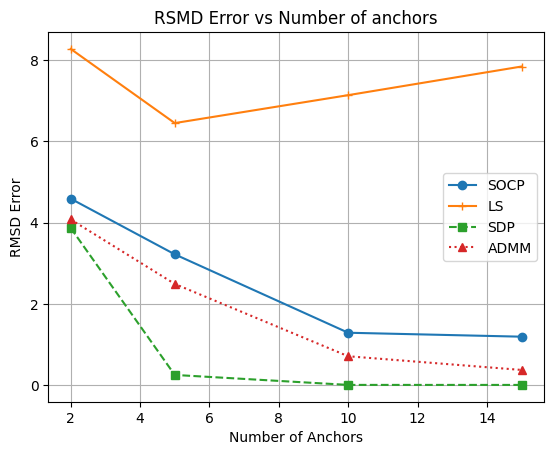

In [ ]:
plt.plot(anchors, np.sum(np.array(socp_t).reshape((4,10)), axis=1), marker='o', linestyle='-', label='SOCP')
plt.plot(anchors, np.sum(np.array(lsq_t).reshape((4,10)), axis=1), marker='+', linestyle='-', label='LS')
plt.plot(anchors, np.sum(np.array(sdp_t).reshape((4,10)), axis=1), marker='s', linestyle='--', label='SDP')
plt.plot(anchors, np.sum(np.array(admm_t).reshape((4,10)), axis=1), marker='^', linestyle=':', label='ADMM')

# Set title and axis labels
plt.title('RSMD Error vs Number of anchors')
plt.xlabel('Number of Anchors')
plt.ylabel('RMSD Error')

# Customize legend
plt.legend()

# Add grid lines
plt.grid(True)

In [ ]:
np.array(admm_t).shape

(1, 8)

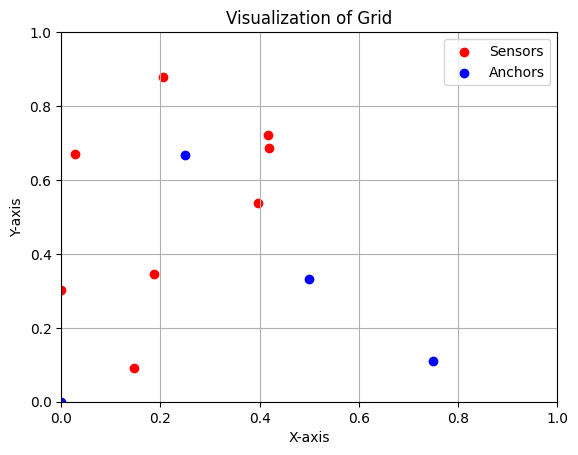

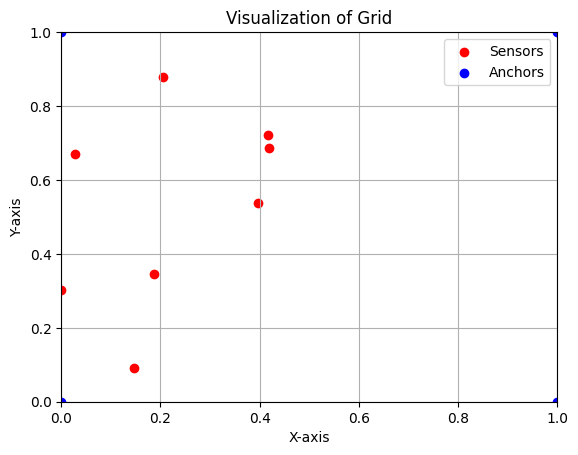

In [ ]:
Nx, Na= 8, 4
it=1
X, A, D, D_hat = get_noisy_data(Nx, Na, r=1.5, noise_std=0, seed = it,  on_perimeter=False, plotter=True)
#X_est = lsq(Nx, A, D, D_hat)
#plotter_with_estimation(X, A, X_est, title='')


X, A, D, D_hat = get_noisy_data(Nx, Na, r=1.5, noise_std=0, seed = it,  on_perimeter=True, plotter=True)
X_est = lsq(Nx, A, D, D_hat)
#plotter_with_estimation(X, A, X_est, title='')


X, A, D, D_hat = get_hull_data(Nx, Na, it, plotter=False, noise_std=0.01)
#X_est = lsq(Nx, A, D, D_hat)
#plotter_with_estimation(X, A, X_est, title='')

# Na= 0 
# X, A, D, D_hat = get_noisy_data(Nx, Na, r=1, noise_std=0, seed = it,  on_perimeter=True, plotter=False)
# X_est = sdp(Nx, A, D, D_hat)
# plotter_with_estimation(X, A, X_est, title='No anchors', anchors=False)

Text(0.5, 0, 'Number of iterations')

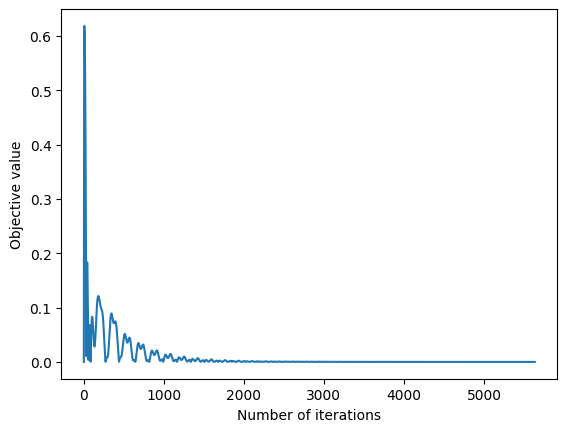

In [ ]:
Nx, Na = 10, 5
X, A, D, D_hat = get_noisy_data(Nx, Na, r=0.5, noise_std=0, seed = it,  on_perimeter=False, plotter=False)
X_est = sdp(Nx, A, D, D_hat)

X_proj, err = sdp_projection(Nx, A, D, D_hat, X_sdp=X_est, lr=0.01, iter=10000)


#plotter_with_estimation(X, A, X_prj)


Text(0.5, 1.0, 'Convergence of Steepest Descent Projection')

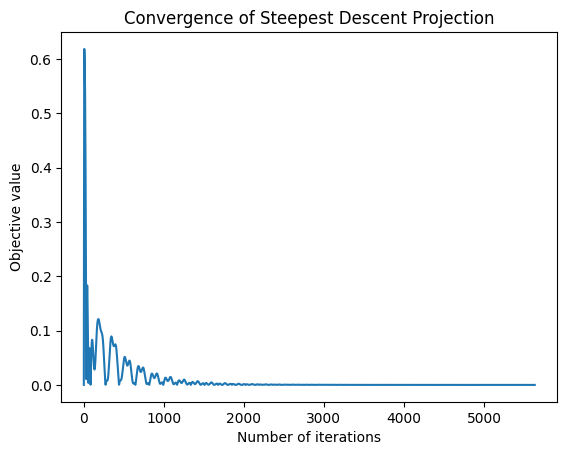

In [ ]:
plt.plot(err)
plt.ylabel('Objective value')
plt.xlabel('Number of iterations')
plt.title('Convergence of Steepest Descent Projection')



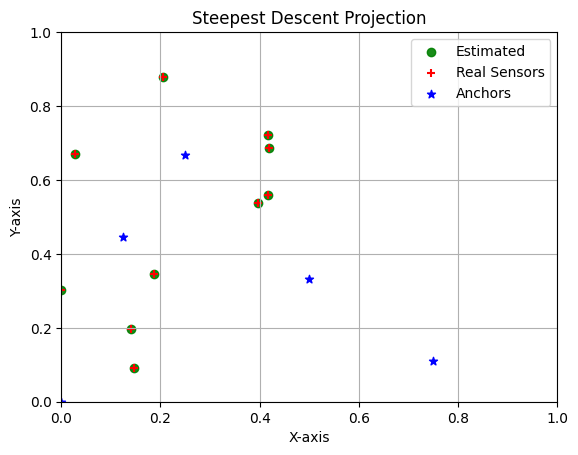

In [ ]:
plotter_with_estimation(X, A, X_proj, title='Steepest Descent Projection')


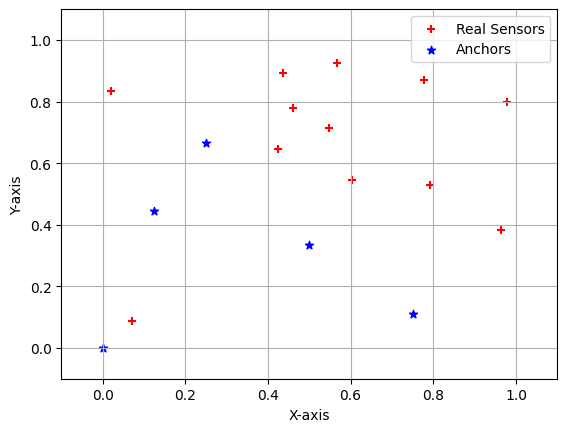

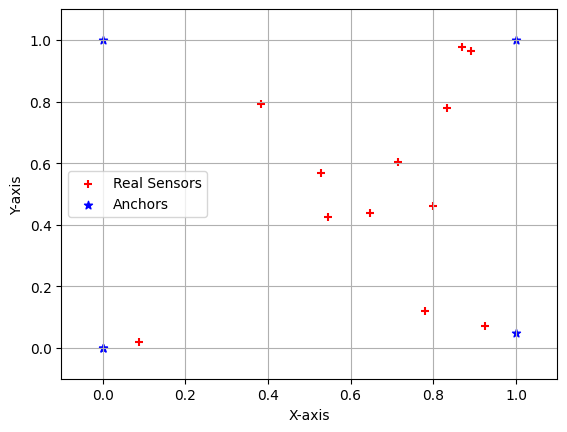

IndexError: ignored

In [ ]:
Nx, Na= 12, 5
it=0
X, A, D, D_hat = get_noisy_data(Nx, Na, r=1.5, noise_std=0, seed = it,  on_perimeter=False, plotter=False)
#X_est = lsq(Nx, A, D, D_hat)
plotter_with_estimation(X, A, None, title='')


X, A, D, D_hat = get_noisy_data(Nx, Na, r=1.5, noise_std=0, seed = it,  on_perimeter=True, plotter=False)
#X_est = lsq(Nx, A, D, D_hat)
plotter_with_estimation(X, A, None, title='')


X, A, D, D_hat = get_hull_data(Nx, Na, it, plotter=False, noise_std=0)
#X_est = lsq(Nx, A, D, D_hat)
plotter_with_estimation(X, A, None, title='')

# Na= 0 
# X, A, D, D_hat = get_noisy_data(Nx, Na, r=1, noise_std=0, seed = it,  on_perimeter=True, plotter=False)
# X_est = sdp(Nx, A, D, D_hat)
# plotter_with_estimation(X, A, X_est, title='No anchors', anchors=False)

In [ ]:
Nx = 1000
Na= 10
import time

X, A, D, D_hat = get_noisy_data(Nx, Na, r=1, noise_std=0, seed = 1,  on_perimeter=False, plotter=False)
# X_socp = socp(Nx, A, D, D_hat)
# socp_rmsd.append(get_rmsd(X, X_socp))
# plotter_with_estimation(X, A, X_socp, title='Anchors on perimeter')

# #print('SOCP done')

# X_lsq = lsq(Nx,A,D,D_hat, x_initial=None)
# lsq_rmsd.append(get_rmsd(X, X_lsq))
# plotter_with_estimation(X, A, X_lsq, title='Anchors on perimeter')

# #print('LS Done')

# start = time.time()
# X_sdp = sdp(Nx, A, D, D_hat)
# end = time.time()
# print(end - start)

# sdp_rmsd.append(get_rmsd(X, X_sdp))
# plotter_with_estimation(X, A, X_sdp, title='Anchors on perimeter')

#print('SDP done')

# X_sdp_lsq = lsq(Nx,A,D,D_hat, x_initial=X_sdp.flatten())
# sdp_lsq_rmsd.append(get_rmsd(X, X_sdp_lsq))
#print('SDP with LS done')
#pdb.set_trace()

# X_proj = sdp_projection(Nx, A, D, D_hat, lr=2e-3)
# proj_rmsd.append(get_rmsd(X, X_proj))
##print('Proj done')

start = time.time()
X_admm = admm(Nx, A, D, D_hat)
end = time.time()
print(end - start)
admm_rmsd.append(get_rmsd(X, X_admm))
plotter_with_estimation(X, A, X_admm, title='Anchors on perimeter')

#print('Admm done')

  0%|          | 0/1000 [00:00<?, ?it/s]